In [2]:
import github_command as gt

In [23]:
gt.push(file_to_transfer='TD7_Image_Captioning_CNN_RNN.ipynb',
       message="model definition",
       repos="TDs_ESILV.git")

In [22]:
gt.push(file_to_transfer='td7_ressources/',
       message="TD7 - ressources",
       repos="TDs_ESILV.git")

In [657]:
from time import time
def timing(f):
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func call took: {0:.2f} sec'.format(te-ts))
        return result
    return wrap

# Image captionning

> Why do we use Embedding: https://towardsdatascience.com/why-do-we-use-embeddings-in-nlp-2f20e1b632d2

> Word2vec from scratch using numpy: https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72

> Image captionning with Keras: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

> Github link of the implementation: https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb

<img src="./td7_ressources/Image_captionning_explanation.png" width=750>

## At Test time

<img src="./td7_ressources/Image_captionning_explanation2.png" width=750>

# What is a Recurrent Neural Network ? 

<img src="./td7_ressources/RNN.png" width=750>

<img src="./td7_ressources/derivationRNN_overview.png" width=750>

<img src="./td7_ressources/derivationRNN_overview2.png" width=750>

<img src="./td7_ressources/concatenationht_minus1_and_x_t.png" width=300>

# You said LSTM ?

<img src="./td7_ressources/LSTM_overview.png" width=750>

### CNN Network part
#### Get the InceptionV3 model trained on imagenet data

In [658]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

### Data part

#### Image descriptions


In [671]:
folder_proj_path="/Users/lucbertin/Downloads/demos/"
flickr_folder = "flickr30k_images/"
captions_file = "results.csv"

In [672]:
import subprocess
subprocess.check_output(["head", "-n", "2", folder_proj_path+flickr_folder+captions_file])

b'image_name| comment_number| comment\n1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .\n'

In [689]:
import pandas as pd
## Open descriptions dataset and append corresponding images
df = pd.read_csv(folder_proj_path+flickr_folder+captions_file, sep='|')
df = df.iloc[:8000]
df.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [690]:
print(df.shape)
df.columns = df.columns.str.replace(' ', '')
print(df.columns)

(8000, 3)
Index(['image_name', 'comment_number', 'comment'], dtype='object')


In [691]:
## Appending startseq and endseq to each comment
df['comment2'] = ("startseq "  +  df.comment
                                        .str.lower()
                                        .str.replace(r"[^a-z0-9 ]", "")
                                        .str.split().str.join(" ") + " endseq")

In [692]:
df[df['comment2'].apply(lambda x: type(x)==float)]

,image_name,comment_number,comment,comment2


In [693]:
#Lol
#df.drop(19999, axis=0, inplace=True)

In [694]:
## Just take words occuring at least 10 times
from collections import Counter
all_words = [item for sublist in df.comment2.str.split(' ').tolist() for item in sublist]
more_than_x_occurences = {k:val for k,val in Counter(all_words).items() if val>=10}

#more_than_x_occurences
df['comment2'] = df['comment2'].str.split(" ").apply(lambda val: [x for x in val if more_than_x_occurences.get(x) is not None])
len(more_than_x_occurences)

862

In [695]:
TARGET_SIZE=(299,299)

In [713]:
def encode(image, model_new):
    """ Function to encode a given image into a vector of size (2048, ) using inceptionV3 """
    from keras.applications.inception_v3 import preprocess_input
    import numpy as np
    image = np.array(image) # transform img to array
    image = np.expand_dims(image, axis=0) # add one dimension for batch (keras needs it)
    image = preprocess_input(image) # preprocess the image for inceptionV3
    fea_vec = model_new.predict(image) # The model beign trained already, get the encoding vector for the image after a forward pass
    fea_vec = np.reshape(fea_vec, -1) # reshape from (1, 2048) to (2048, )
    return fea_vec

def create_dictionnaries_for_string_convertion(vocab):
    """ Create an index to word dictionnary and a word to index one """
    ixtoword, wordtoix = {}, {}
    ix = 1
    for w in vocab:
        wordtoix[w] = ix
        ixtoword[ix] = w
        ix += 1
    return ixtoword, wordtoix

ixtoword, wordtoix = create_dictionnaries_for_string_convertion(vocab=more_than_x_occurences)
maximum_length_caption_on_all_dataset = max(df.comment2.apply(len)) # max caption length ( for homogeneity of input vectors )
maximum_length_caption_on_all_dataset

47

In [714]:
" ".join(df[df["comment2"].apply(lambda x: len(x)==maximum_length_caption_on_all_dataset)].comment2.values[0])

'startseq five all wearing helmets and goggles line up in a snowy in a forest in front of their they are all wearing black snow pants and from left to right they are wearing a black coat white coat red coat blue coat and black coat endseq'

In [715]:
str(ixtoword)[:100], str(wordtoix)[:100]

("{1: 'startseq', 2: 'two', 3: 'young', 4: 'guys', 5: 'with', 6: 'hair', 7: 'look', 8: 'at', 9: 'their",
 "{'startseq': 1, 'two': 2, 'young': 3, 'guys': 4, 'with': 5, 'hair': 6, 'look': 7, 'at': 8, 'their': ")

<img src="./td7_ressources/one_hot_encode_for_vocabulary.png" width=750>

#### encoding sequence and padding (for creation of inputs) #####

In [719]:
def encoding__padding_inputs_seq(sequence, vocab, shift, max_length):
    import numpy as np
    encoding = list(map(vocab.get, sequence[:shift+1]))
    encoding += [0]*(max_length-len(encoding))
    return np.array(encoding)

In [725]:
a = ["two", "women", "are", "in", "the","kitchen"] 

In [726]:
[encoding__padding_inputs_seq(sequence=a, shift=i, vocab=wordtoix, max_length=6) for i in range(len(a))]

[array([2, 0, 0, 0, 0, 0]),
 array([  2, 192,   0,   0,   0,   0]),
 array([  2, 192,  20,   0,   0,   0]),
 array([  2, 192,  20,  14,   0,   0]),
 array([  2, 192,  20,  14,  15,   0]),
 array([  2, 192,  20,  14,  15,  91])]

#### one-hot encoding based on vocab encoding for outputs (result in softmax) #####

In [727]:
def encoding_outputs_from_seq(sequence, shift, vocab):
    import numpy as np
    encoding = vocab.get(sequence[shift])
    return np.eye(len(vocab)+1)[encoding, :]

In [13]:
#[encoding_outputs_from_seq(sequence=a, shift=i, vocab=wordtoix) for i in range(len(a))]

## Generate a batch of images then the sequence of Xt inputs with respective targets Yt

In [730]:
def load_batch_of_images(df, batch_size, model_for_encoding, folder_imgs_path, TARGET_SIZE=TARGET_SIZE, epochs=1000):
    """ This function will only load batch_size pictures at a time (for computations)"""
    from PIL import Image as Im
    import pandas as pd, numpy as np
    a=0
    # iterate for ever (check Keras documentation)
    while a<epochs:
        a+=1
        #print("shuffling...")
        ## shuffling
        df = df.sample(n=len(df))
        ## One epoch = One loop
        for batch_i in range(1, len(df)//batch_size+1):
            print("batch number : {} | batch_size : {}".format(batch_i, batch_size))
            
            ### ======== Images encoding part ======== ####
            # take a sample from the main dataset
            df_sub = df.iloc[(batch_i-1)*batch_size : (batch_i)*batch_size]#.copy()#reset_index(drop=True)
            df_sub_images, df_sub_comments = df_sub[['image_name']].copy(), df_sub[["image_name", "comment2"]].copy()
            #display(df_sub)
            
            #print("opening corresponding images in {}".format(folder_imgs_path))
            # open corresponding images in new column
            df_sub_images['image'] = df_sub_images.image_name.apply( lambda x: Im.open(folder_imgs_path+x).resize(TARGET_SIZE))
            
            #print("encoding images using Inceptionv3 model frozen layers")
            # transform to array, preprocess and encode images
            df_sub_images['image'] = df_sub_images.image.apply(lambda x: encode(x, model_for_encoding))
            
            
            ### ======== Word sequence convertion to index then embedding part ======== ####
            #print("\nstarting sequence convertion to index based on entire dataset vocabulary")
            df_sub_comments['input_sequences']  = df_sub_comments.comment2.apply(lambda x: 
                        [encoding__padding_inputs_seq(sequence=x, shift=i, vocab=wordtoix, max_length=maximum_length_caption_on_all_dataset) for i in range(len(x))])
            df_sub_comments['output_sequences'] = df_sub_comments.comment2.apply(lambda x:
                        [encoding_outputs_from_seq(sequence=x, shift=i, vocab=wordtoix) for i in range(len(x))])
            df_sub_comments = df_sub_comments.apply(lambda x: x.apply(pd.Series).stack()).reset_index(drop=True).ffill()
            
            #print("🔥inputs ready.\n")
            #display(df_sub_images)
            #display(df_sub_comments)
            
            df_sub = df_sub_images.merge(df_sub_comments, on=["image_name"])
            #display(df_sub)
            ## problem in input1 shape: not sum of both shapes
            # [[input1, input2],  output]
            yield [ [np.stack(df_sub.image), np.stack(df_sub.input_sequences)], np.stack(df_sub.output_sequences) ]

In [23]:
#[[ input1, input2], output] = list(load_batch_of_images(df, batch_size=2, 
#                                                model_for_encoding=model_new, 
#                                                 folder_imgs_path=folder_proj_path+flickr_folder, epochs=1))

In [47]:
input2.shape

(30, 78)

In [48]:
output.shape

(30, 5464)

In [50]:
input1.shape

(30, 2048)

## Word Embedding
### gives a vector representation of words converted into numerical indexes


<img src="./td7_ressources/GloVe_word_representation.png" width=750>

In [731]:
glove_file="glove/glove.6B.200d.txt"

In [732]:
subprocess.check_output(["head", "-n", "1", folder_proj_path+glove_file])

b'the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0.078186 0

### Load the whole embedding into memory



In [733]:
import numpy as np
embeddings_index = {} # empty dictionary
with open(folder_proj_path+glove_file, encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Loaded {} word vectors.'.format(len(embeddings_index)))

Loaded 400000 word vectors.


### transform integer vector representation to dense one

In [734]:
embedding_dim = 200

* embeddings_index associate a **word** to a **vector representation**
* wordtoix associate a **word** to a **integer number**



In [735]:
# Get 200-dim dense vector for each of the 5464 words in out vocabulary (word_to_idx)
embedding_matrix = np.zeros((len(wordtoix)+1, 200)) # 200: embedding dim: the Dense representation of the word with '200 like features'
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [736]:
embedding_matrix.shape

(863, 200)

* To each 5464 word is **associated a vector** 
* It's a **stack of vectors and the index i of the matrix is associated to the index of the word itself**

<img src="./td7_ressources/using_glove_in_embedding.png" width=750>

<img src="./td7_ressources/embedding_layer_in_NN.png" width=750>

<img src="./td7_ressources/embedding_again.png" width=750>

<img src="./td7_ressources/transformation_by_Embedding.png" width=750>

<img src="./td7_ressources/output_embedding_layer.png" width=750>

<img src="./td7_ressources/how_works_the_embedding.png" width=750>

## Model definition

In [816]:
maximum_length_caption_on_all_dataset
vocab_size = len(wordtoix) + 1
embedding_dim = 200 # dense words representation

In [ ]:
from keras.layers import Dense, Dropout, LSTM, Input, Embedding, add
from keras.models import Model

# image feature extractor model (as 2048 vector of features)
inputs1 = Input(shape=(2048,))
fe1     = Dropout(0.5)(inputs1)
fe2     = Dense(256, activation='relu')(fe1)

# partial caption sequence model (as max size of sequences (padding: 78 values in list))
inputs2 = Input(shape=(maximum_length_caption_on_all_dataset,)) 
se1     = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(inputs2)
se2     = Dropout(0.5)(se1)
se3     = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs  = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [830]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 47)           0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 47, 200)      172600      input_39[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 2048)         0           input_38[0][0]                   
__________________________________________________________________________________________________
dropout_36

In [831]:
from keras.optimizers import adam

In [832]:
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.1))

In [770]:
from keras.optimizers import rmsprop
model.compile(loss='categorical_crossentropy', optimizer=rmsprop(lr=0.01, rho=0.9))

## Train, Test split

In [747]:
## shuffling
df = df.sample(n=len(df))
## splitting
train_size = 0.9
df_train, df_test = df.iloc[:round(train_size*len(df))], df.iloc[round(train_size*len(df)):]

In [748]:
df.shape, df_train.shape, df_test.shape

((8000, 4), (7200, 4), (800, 4))

In [745]:
df_train = df_train.iloc[:round(0.0001*len(df_train))]

In [746]:
df_train

,image_name,comment_number,comment,comment2
2541,11610969.jpg,1,People are gathered around and walking buy a ...,"[startseq, people, are, gathered, around, and,..."


## prepare_validation_data

In [749]:
validation_data = list(load_batch_of_images(df_test, batch_size=len(df_test), 
                                                 model_for_encoding=model_new, 
                                                 folder_imgs_path=folder_proj_path+flickr_folder, 
                                                                    epochs=1))

batch number : 1 | batch_size : 800


159 photos and input sequences processed in 58 seconds

In [750]:
[[ input1_val, input2_val], output_val] = validation_data[0]

In [751]:
input1_val.shape, input2_val.shape, output_val.shape

((14435, 2048), (14435, 47), (14435, 863))

In [752]:
epochs = 20
batch_size = 32
steps = len(df_train)//batch_size

In [753]:
steps

225

## Callbacks and model saving

In [833]:
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
#checkpoint = ModelCheckpoint('RNN_model.sav', monitor='val_loss', period=2, save_best_only=True)

In [834]:
val_losses_after_each_batch = {}

In [835]:
class NbCallFunction:
    """ This is a decorator to count the number of times a function has been called
    It will be used to retrieve the image number to put it in working directory"""
    def __init__(self, function):
        self.callNumber = 0
        self.function = function
    def __call__(self, *args, **kwargs):
        ## onCall
        self.callNumber += 1
        return self.function(*args, **kwargs)

In [836]:
@NbCallFunction
def compute_val_loss(batch, logs={}):
    ## every 5 call 
    if compute_val_loss.callNumber  % 80 == 0:
        val_loss = model.evaluate(*validation_data[0])
        val_losses_after_each_batch[compute_val_loss.callNumber] = val_loss
        model.loss
        print("training_loss: {} | val_loss: {}".format(logs.get('loss'), val_loss))

In [837]:
lambda1 = LambdaCallback(on_batch_begin=compute_val_loss)

In [838]:
MyHistory = model.fit_generator(generator=load_batch_of_images(
                            df_train, batch_size=4, 
                            model_for_encoding=model_new, 
                            folder_imgs_path=folder_proj_path+flickr_folder), 
                    steps_per_epoch=steps,
                    epochs=1,
                    validation_data = validation_data[0], 
                    callbacks=[checkpoint, lambda1],
                    verbose=1)

Epoch 1/1
batch number : 1 | batch_size : 16
batch number : 2 | batch_size : 16
 41/225 [====>.........................] - ETA: 10:26 - loss: 14.5778

KeyboardInterrupt: 

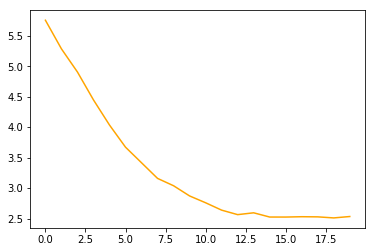

In [795]:
plt.plot(MyHistory.history['loss'], color='orange')

In [163]:
import matplotlib.pyplot as plt

In [164]:
%matplotlib inline

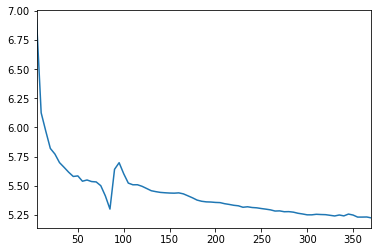

In [167]:
pd.Series(val_losses_after_each_batch).plot()

In [168]:
model.evaluate(*validation_data[0])

2283/2283 [==============================] - 3s 1ms/step


5.224658828005162

In [175]:
validation_data[0][0]

[array([[0.37129483, 0.2788668 , 0.40370244, ..., 0.16719949, 0.24561413,
         0.3307584 ],
        [0.37129483, 0.2788668 , 0.40370244, ..., 0.16719949, 0.24561413,
         0.3307584 ],
        [0.37129483, 0.2788668 , 0.40370244, ..., 0.16719949, 0.24561413,
         0.3307584 ],
        ...,
        [0.28999308, 0.10006949, 0.8342191 , ..., 0.04062789, 0.9622983 ,
         0.49542364],
        [0.28999308, 0.10006949, 0.8342191 , ..., 0.04062789, 0.9622983 ,
         0.49542364],
        [0.28999308, 0.10006949, 0.8342191 , ..., 0.04062789, 0.9622983 ,
         0.49542364]], dtype=float32),
 array([[   1,    0,    0, ...,    0,    0,    0],
        [   1,  255,    0, ...,    0,    0,    0],
        [   1,  255, 3712, ...,    0,    0,    0],
        ...,
        [   1,   30,  297, ...,    0,    0,    0],
        [   1,   30,  297, ...,    0,    0,    0],
        [   1,   30,  297, ...,    0,    0,    0]])]

## Exploit results

In [331]:
df_test.loc[df_test.image_name == "7111002063.jpg"].comment2.values[0]

['startseq',
 'two',
 'soldiers',
 'train',
 'a',
 'police',
 'dog',
 'as',
 'it',
 'grabs',
 'hold',
 'of',
 'one',
 'of',
 'the',
 'soldier',
 's',
 'training',
 'tools',
 'with',
 'its',
 'mouth',
 'endseq']

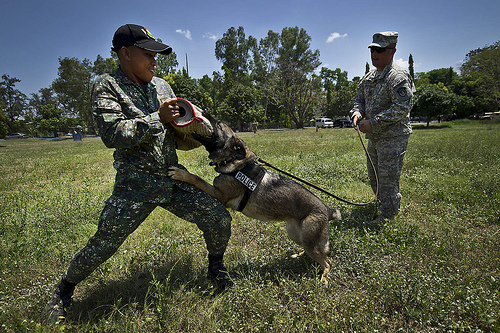

In [319]:
Im.open(folder_proj_path+flickr_folder+"7111002063.jpg")

In [332]:
## One image vector representation
image_vector = encode(Im.open(folder_proj_path+flickr_folder+"7111002063.jpg").resize(TARGET_SIZE), model_new)
image_vector.shape
image_vector

array([0.13117808, 0.21449879, 0.39646235, ..., 0.31189302, 0.4604663 ,
       0.22170103], dtype=float32)

In [333]:
## A sentence starting with 'startseq' of size: maximum_length_caption_on_all_dataset
sequence_startseq_test = encoding__padding_inputs_seq(["startseq"], vocab=wordtoix, shift=0, max_length=maximum_length_caption_on_all_dataset)
sequence_startseq_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [370]:
def decode(one_hot_encoding, reversed_vocab=ixtoword, shift=0):
    return " ".join(list(map(ixtoword.get, np.argmax(one_hot_encoding, axis=1)+shift)))

In [379]:
2.9454739e-06 in result

True

In [403]:
wordtoix.get("endseq")

18

In [473]:
result

array([[2.9454739e-06, 4.5556277e-03, 2.6817946e-02, ..., 4.2003953e-06,
        3.3842209e-06, 1.2607335e-05]], dtype=float32)

In [491]:
result.argsort().reshape(-1)[-2]

30

In [808]:
df_train.sample(2)

,image_name,comment_number,comment,comment2
7483,142786312.jpg,3,The young flower girl carefully carries her b...,"[startseq, the, young, flower, girl, carries, ..."
372,1020651753.jpg,2,a black and white dog jumping in the air to g...,"[startseq, a, black, and, white, dog, jumping,..."


In [796]:
def predict_output_sentence_(model, image_name, vocab):
    image = Im.open(folder_proj_path+flickr_folder+image_name).resize(TARGET_SIZE)
    image_vector = encode(image, model_new)
    plt.imshow(image)
    print(df.loc[df.image_name == image_name].comment2.values[0])
    
    sequence_startseq_test = \
            encoding__padding_inputs_seq(["startseq"], vocab=vocab, 
                                         shift=0, max_length=maximum_length_caption_on_all_dataset)
    
    result = model.predict(x=[
        np.expand_dims(image_vector, axis=0),
        np.expand_dims(sequence_startseq_test, axis=0)])
    
    i=0
    while not decode(result, shift=1) == 'endseq' and i < maximum_length_caption_on_all_dataset-1:
        i+=1
        sequence_startseq_test[i] = result.argsort().reshape(-1)[-1]
        #print(sequence_startseq_test)
        result = model.predict(x=[
            np.expand_dims(image_vector, axis=0),
            np.expand_dims(sequence_startseq_test, axis=0)])
    return str([ixtoword.get(elem) for elem in  sequence_startseq_test])

['startseq', 'the', 'white', 'dog', 'is', 'playing', 'in', 'a', 'green', 'field', 'with', 'a', 'yellow', 'toy', 'endseq']


"['startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq', 'startseq']"

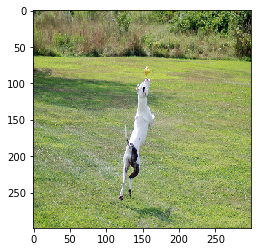

In [810]:
predict_output_sentence_(model, "1020651753.jpg", vocab=wordtoix)

In [647]:
df_train.sample(3)

,image_name,comment_number,comment,comment2
104878,4569657671.jpg,3,A man and woman sitting near the street .,"[startseq, a, man, and, woman, sitting, near, ..."
158379,96059112.jpg,4,A father and his child are crossing the lawn .,"[startseq, a, father, and, his, child, are, cr..."
106523,461139063.jpg,3,A woman examining a lamp .,"[startseq, a, woman, examining, a, lamp, endseq]"


In [366]:
result.shape

(1, 5464)

In [367]:
result

array([[2.9454739e-06, 4.5556277e-03, 2.6817946e-02, ..., 4.2003953e-06,
        3.3842209e-06, 1.2607335e-05]], dtype=float32)

In [369]:
decode(result, shift=0)

'endseq'

In [354]:
ixtoword.get(1)

'startseq'